In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from skimage import transform
from tqdm import tqdm
import gc

In [2]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()

X_train_r = np.asarray(x_train)/255.0
X_test_r = np.asarray(x_test)/255.0

del x_train
del x_test

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
print(y_train.shape)

(50000, 1)


In [4]:
print("Shape of X Train : ", X_train_r.shape)
print("Shape of X Test : ", X_test_r.shape)

Shape of X Train :  (50000, 32, 32, 3)
Shape of X Test :  (10000, 32, 32, 3)


[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


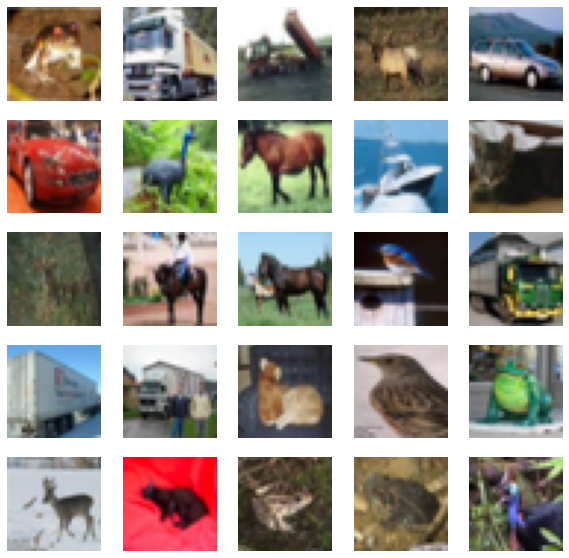

In [5]:
plt.figure(figsize = (10, 10))
count = 1
idd = 0
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, count)
        plt.imshow(X_train_r[idd])
        plt.axis('off')
        idd += 1
        count += 1

print(y_train[0:10])

In [6]:
from keras.utils.np_utils import to_categorical

#For training data
y_trainHot = np.uint8(to_categorical(y_train, num_classes = 10))

In [7]:
#The class division and number of images in each class
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

In [8]:
from sklearn.model_selection import train_test_split


#Splitting the data for training and testing
X_train_s, X_valid_s, y_train, y_valid = train_test_split(X_train_r, y_trainHot, test_size=0.2, random_state=42)

#del X_train_r

In [9]:
#Initializing MobileNet as Base Model for Transfer Learning
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(include_top=False, weights='imagenet',
            input_shape=(32,32,3), classes=y_train.shape[1])

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

#Adding layers to base model of MobileNet

model = Sequential()

#Creating base layer of VGG19
model.add(base_model)

model.add(Flatten())

#Adding the Dense Layers and Dropout
model.add(Dense(512,activation=('relu'))) 

model.add(Dense(256,activation=('relu'))) 

model.add(Dropout(0.3))

model.add(Dense(128,activation=('relu')))

model.add(Dropout(0.2))

model.add(Dense(10,activation=('softmax')))

In [11]:
#Visualizing Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

In [12]:
from tensorflow.keras.optimizers import Adam

num_epochs = 20
batch_size = 32

#Compiling the model
opt = Adam(learning_rate = 1e-4)
model.compile(loss = "categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [13]:
print(X_train_s.shape)
print(y_train.shape)
print(y_valid.shape)

(40000, 32, 32, 3)
(40000, 10)
(10000, 10)


In [14]:
H = model.fit(X_train_s,y_train, 
              batch_size = batch_size,
              validation_data = (X_valid_s, y_valid), 
              epochs = num_epochs)

Epoch 1/20
1250/1250 [==============================] - 345s 271ms/step - loss: 1.8601 - accuracy: 0.3297 - val_loss: 2.0880 - val_accuracy: 0.2733
Epoch 2/20
1250/1250 [==============================] - 337s 270ms/step - loss: 1.3902 - accuracy: 0.5163 - val_loss: 1.6642 - val_accuracy: 0.5134
Epoch 3/20
1250/1250 [==============================] - 338s 270ms/step - loss: 1.1859 - accuracy: 0.5964 - val_loss: 1.0964 - val_accuracy: 0.6613
Epoch 4/20
1250/1250 [==============================] - 338s 270ms/step - loss: 1.0548 - accuracy: 0.6456 - val_loss: 0.9575 - val_accuracy: 0.6942
Epoch 5/20
1250/1250 [==============================] - 345s 276ms/step - loss: 0.9445 - accuracy: 0.6843 - val_loss: 0.8720 - val_accuracy: 0.7090
Epoch 6/20
1250/1250 [==============================] - 343s 274ms/step - loss: 0.8586 - accuracy: 0.7104 - val_loss: 0.7719 - val_accuracy: 0.7394
Epoch 7/20
1250/1250 [==============================] - 342s 274ms/step - loss: 0.7905 - accuracy: 0.7366 - val_

In [15]:
def plot_confusion_matrix(cm):

    #Setting the figure size
    fig, ax = plt.subplots(figsize=(12,5))
    
    #Creating the pandas dataframe
    d_cm = pd.DataFrame(cm)
    
    sn.set(font_scale=1)
    
    #Setting the fontsize and plotting the heatmap
    sn.heatmap(d_cm, annot=True, fmt='g',annot_kws={"size": 16})
    
    plt.title('Confusion matrix')
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label');

    plt.show()
    
def acc_versus_epochs(hist):
    
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,2)
    loss_train = hist.history['accuracy']
    loss_val = hist.history['val_accuracy']
    epochs = range(1,21)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    loss_train = hist.history['loss']
    loss_val = hist.history['val_loss']
    epochs = range(1,21)
    plt.plot(epochs, loss_train, 'g', label='Training Loss')
    plt.plot(epochs, loss_val, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

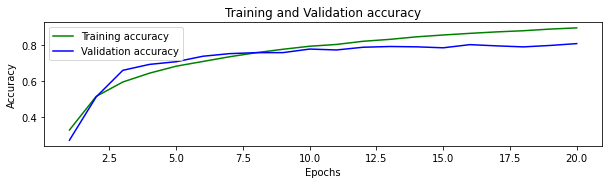

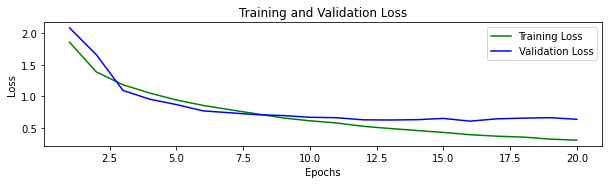

In [16]:
#Plotting the accuracy versus epochs
acc_versus_epochs(H)

313/313 [==============================] - 15s 40ms/step


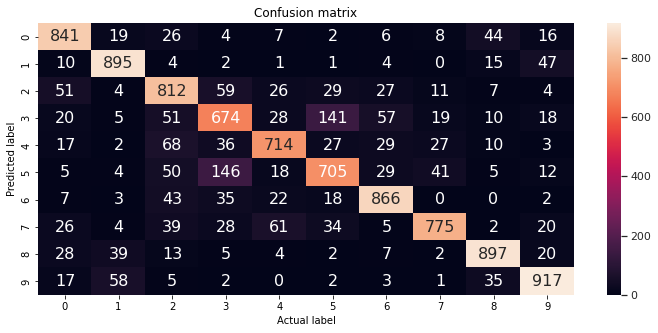

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

y_pred = model.predict(X_valid_s)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_valid,axis=1)

confusion_mtx = [Y_true, Y_pred_classes]

plot_confusion_matrix(confusion_matrix(Y_true,Y_pred_classes))